In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.linear_model import LinearRegression
from matplotlib.colors import ListedColormap

# imports from 
from utils_orbs.orb_paths import SetupPaths
import utils_orbs.readsubfHDF5Py3 as readSub
from utils_orbs.merger_trees import TraceMergerTree
from utils_orbs.readMergerHistoryFiles import FindHistory
from utils_orbs.vectorCorrection import vectorCorrection as vector

paths = SetupPaths()

imported h5py...
modules seem to have loaded?


In [2]:
plt.show();
plt.rcParams.update({'font.size':20,"xtick.direction":"in","ytick.direction":"in", 
                     "xtick.top":True, "ytick.right":True,"text.usetex":False,
                     "xtick.labelsize":18,"ytick.labelsize":18,
                     "xtick.minor.top":True, "ytick.minor.right":True,
                     "xtick.minor.visible": True,
                     "ytick.minor.visible": True})

# Function for color map creation

In [3]:
def make_colorarray(color_val, f):
    """
    creates the correctly scaled array of values from 0,1 for one rgb val
    ---
    inputs: 
    - color_val: float
        float representing one of the r, g, or b values of desired custom colormap
    - f: float
        the location of custom color in colorbar (from 0-1)  
        f = 1, color scale will be from white to rgb
        f = 0, color scale will be from rgb to black
        f = 0.5 - 1, color scale slowly transitions from white to color, then quickly from color to black
        f = 0 - 0.5, color scale quickly transition from white to color, then slowly from color to black
        recommend 0.25 for sparse data with low vals, or 0.75 for sparse at higher vals
    --- 
    returns: 
    - array of length 256, containing linearly spaced values from 0-f and f-1
    ---
    Note: if f*N is not an integer, it will be rounded down to the nearest int
    """
    
    N = 256
    f_val = int(N * f)
    
    white_to_color = np.linspace(1, color_val, f_val)
    color_to_black = np.linspace(color_val, 0, N-f_val)
    
    combined = np.concatenate((white_to_color, color_to_black))
    return combined

def make_colormap(rgb_list, where_color):
    """ 
    creates colormap with alpha = 0
    ---
    inputs: 
    - rgb_list: list or array
                contains 3 elements for the r, g, and b color vals respectively
    - where_color: float in [0,1]
                the location of the colorbar where the color is placed
                if where_color = 1, color scale will be from white to rgb
                if where_color = 0, color scale will be from rgb to black
                if where_color = f, color scale will go from white to rgb at 
                the fraction f of the total colorbar size, then rgb to black
    --- 
    returns:
    - ListedColormap 
    """
        # add below later when you have time
        #     if where_color
    
        #     else: 
        #         raise TypeError("arg 'where_color' should be a float from 0-1")
    
    N = 256 # rgb 
    vals = np.ones((N, 4))
    
    # replace the r, b, and g columns with rgb-specific arrays
    for i in range(3):
        vals[:, i] = make_colorarray(rgb_list[i], where_color)
        
    try: 
        map_object = ListedColormap(vals)
    except NameError:
        err_string = "You have not imported the required matplotlib module.\n\
                      Please add 'from matplotlib.colors import ListedColormap'"
        print(err_string)
    
    return map_object


In [4]:
# defining color palette & colormaps for plotting
palette = {"low":"olive", "high":"salmon", 
           "difference":"#2C1D11", "difference2":"#464646"}   
        
        
g_rgb = [128/256, 128/256, 38/256] # green rgb vals
p_rgb = [234/256, 134/256, 119/256] # pink rgb vals

green_map = make_colormap(g_rgb, 0.25)
pink_map = make_colormap(p_rgb, 0.25)

# Test to see if fitting works with fake data

In [5]:
xdat = np.arange(0,100)
ydat = xdat*2 + np.random.normal(0,5,len(xdat))
print(xdat.shape)

xdat = np.reshape(xdat,(len(xdat),1))
# reg = LinearRegression().fit(X, y)
print(xdat.shape)


(100,)
(100, 1)


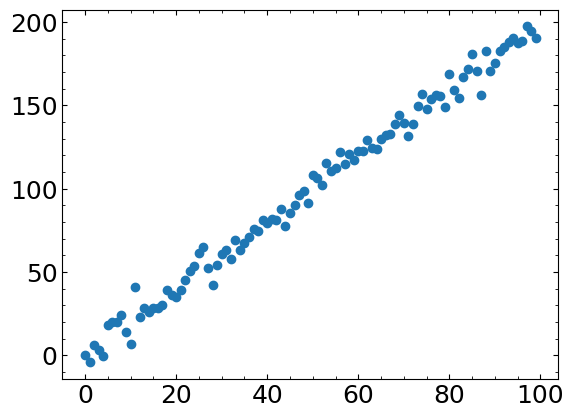

In [6]:
plt.scatter(xdat, ydat)
plt.show()

In [7]:
reg = LinearRegression().fit(xdat, ydat)

slope = reg.coef_
intercept = reg.intercept_

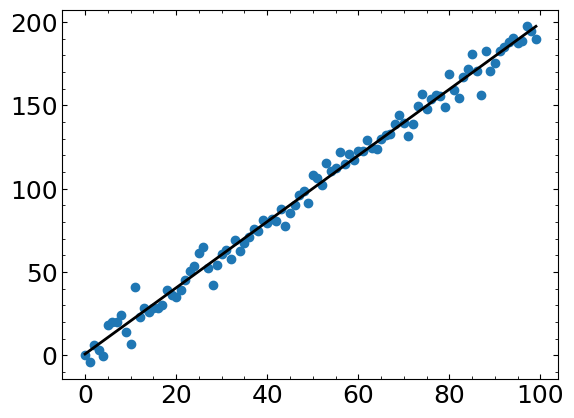

In [8]:
plt.scatter(xdat, ydat)
plt.plot(xdat, slope*xdat + intercept, c='black',lw=2)
plt.show() 

 # Import data

In [9]:
low = {}
f = h5py.File(f"{paths.path_data}hail-mary/unique_orbits.hdf5",'r')
for key, val in f.items():
    low[key] = np.array(val)
f.close()

high = {}
f = h5py.File(f"{paths.path_data}big-bad/unique_orbits_massive.hdf5",'r')
for key, val in f.items():
    high[key] = np.array(val)
f.close()

f = h5py.File(f"{paths.path_data}snapshot_data.hdf5",'r')
convert = {}
for key, val in f.items():
    convert[key] = np.array(val)
f.close()

# Merger time vs. separation (2d hist)

In [10]:
def add_2dhist(data, snapshot, ax, cmap=green_map, vmax=20):
    lbt_at_snap = convert["Lookback Time"][snapshot]
    seps_at_snap = data['Separations'][:,snapshot]
    postinfall_at_snap = data['InfallSnapshot'] <= snapshot # infall snapshot must be = or prior to 40
    merge_later = data['MergeSnapshot'] > snapshot # merger snapshot must be after

    postinfall_willmerge = postinfall_at_snap&merge_later # merging pairs 
    seps_will_merge = np.where(postinfall_willmerge, seps_at_snap, np.nan)

    mask_lower10 = (seps_will_merge > 10)

    seps_for_hist = seps_will_merge[mask_lower10]
    number_seps = len(seps_for_hist)
    
    mergesnap = data['MergeSnapshot'][mask_lower10]
    mergetimes = convert["Lookback Time"][mergesnap]
    mt_for_hist = lbt_at_snap - mergetimes
        
    kwargs = {"range":[[0,300],[0,8]],
              "bins": [int(15),int(16)],
              "cmap":cmap,
              "weights":100*np.ones(number_seps)/number_seps,
              "vmin":0,
              "vmax":vmax
             }
    
    h,_,_,im0 = ax.hist2d(seps_for_hist, mt_for_hist,**kwargs)

    return h, im0, number_seps


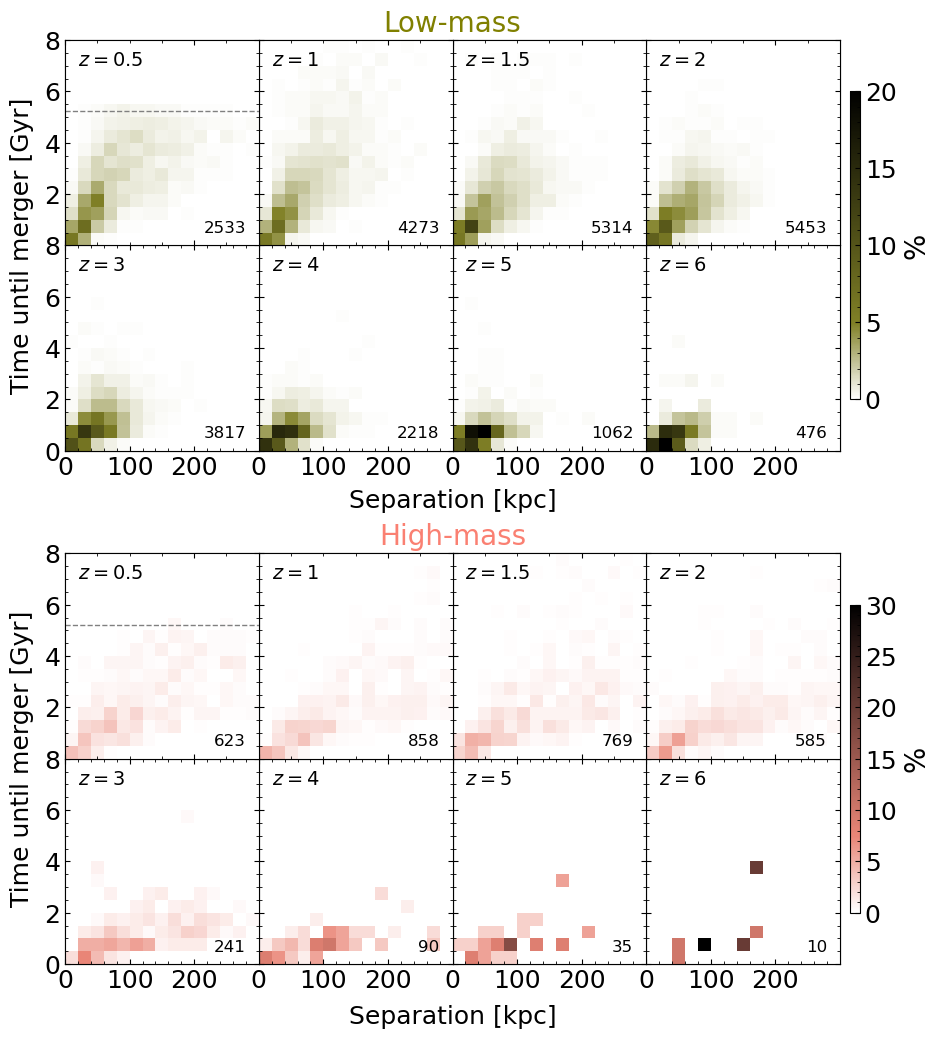

In [11]:
fig = plt.figure(figsize=(10, 12))
outer = gridspec.GridSpec(2, 1, wspace=0.2, hspace=0.25)

title_string = ["Low-mass","High-mass"]
title_color = [palette['low'],palette['high']]

redshift = [[0.5,1,1.5,2],[3,4,5,6]]
snaps = [[67,50,40,33],[25,21,17,13]]
timeleft = convert["Lookback Time"][67]
locs = {}

for outnum in range(2):
    inner = gridspec.GridSpecFromSubplotSpec(2, 4,
                    subplot_spec=outer[outnum], wspace=0, hspace=0)

    ax = plt.Subplot(fig, outer[outnum])
    ax.set_title(title_string[outnum], color=title_color[outnum], fontsize=20)
    ax.set_xticks([])
    ax.set_yticks([])
    
    fig.add_subplot(ax)
    locs[outnum] = ax.get_position()
    
    for rownum in range(2)[::-1]:        
        for colnum in range(4)[::-1]:
            ax = plt.Subplot(fig, inner[rownum,colnum])
            ax.set(ylim=(0,8),xlim=(0,300))
            snapnum = snaps[rownum][colnum]
            
            if outnum == 0:
                _,grbar, numseps = add_2dhist(low, snapnum, ax)
                
            elif outnum == 1:
                _,pnkbar, numseps = add_2dhist(high, snapnum, ax, cmap=pink_map, vmax=30)
            
            ax.text(20,7, r'$z=%s$' % (redshift[rownum][colnum]),fontsize=14)

            ax.text(280,0.5, r'%i' % (numseps),fontsize=12,ha='right')
#             ax.text(280,0.4, r'Pairs',fontsize=12,ha='right')
            
            if (colnum == 0)&(rownum == 0):
                ax.axhline(timeleft, linestyle="dashed", lw=1, color='grey')
            
            # managing ticks:
            if colnum != 0:
                ax.tick_params(labelleft=False)    
            
            if rownum != 1:
                ax.tick_params(labelbottom=False)    
                ax.set_yticks(ticks=np.arange(2,9,2))
                
            else: 
                ax.set_xticks(ticks=[0, 100, 200])
            ax.set_ylabel(" ")
            ax.set_xlabel(" ")
            
            fig.add_subplot(ax)

# locations : 
xloc = locs[0].x0+((locs[0].x1-locs[0].x0)/2)    
top_yheight = locs[0].y1-locs[0].y0
top_yloc = locs[0].y0+(top_yheight/2)
bottom_yheight = locs[1].y1-locs[1].y0
bottom_yloc = locs[1].y0+(bottom_yheight/2)

# colorbar:
loc_xcax = 0.91
loc_ycax = locs[0].y0+top_yheight/8
height_cax = 6*top_yheight/8
width_cax = 0.01
colorbar_kwargs = {"aspect":30, "location":"right",
                   "shrink":0.8,"pad":0.01,"label":"%"}

cax = fig.add_axes([loc_xcax, locs[0].y0+top_yheight/8, width_cax, height_cax])
fig.colorbar(grbar, cax=cax, **colorbar_kwargs)

cax = fig.add_axes([loc_xcax, locs[1].y0+top_yheight/8, width_cax, height_cax])
fig.colorbar(pnkbar, cax=cax, **colorbar_kwargs)


## labels:
xlabel_kwargs = {"fontsize":18, 
                 "ha":'center', 
                 "weight":'medium'}

ylabel_kwargs = {"rotation":'vertical',
                 "fontsize":18, 
                 "va":'center', 
                 "weight":'medium'}

# top plot:  
fig.text(0.07, top_yloc, r"Time until merger [Gyr]", **ylabel_kwargs) 
fig.text(xloc, 0.49, "Separation [kpc]", **xlabel_kwargs) 

# bottom plot: 
fig.text(0.07, bottom_yloc, r"Time until merger [Gyr]", **ylabel_kwargs) 
fig.text(xloc, 0.06, "Separation [kpc]", **xlabel_kwargs) 

fig.show()
# plt.savefig("../../plots/bet-on-it/8_2Dhist.png", bbox_inches="tight")

## Test fit with z=0.5 for low mass:

In [12]:
# gather data
data = low
snapnum = 67

lbt_at_snap = convert["Lookback Time"][snapnum]
seps_at_snap = data['Separations'][:,snapnum]
postinfall_at_snap = data['InfallSnapshot'] <= snapnum # infall snapshot must be = or prior to 40
merge_later = data['MergeSnapshot'] > snapnum # merger snapshot must be after
postinfall_willmerge = postinfall_at_snap&merge_later # merging pairs 
seps_will_merge = np.where(postinfall_willmerge, seps_at_snap, np.nan)

mask_lower10 = (seps_will_merge > 10)

seps_for_hist = seps_will_merge[mask_lower10]
number_seps = len(seps_for_hist)

mergesnap = data['MergeSnapshot'][mask_lower10]
mergetimes = convert["Lookback Time"][mergesnap]
mt_for_hist = lbt_at_snap - mergetimes

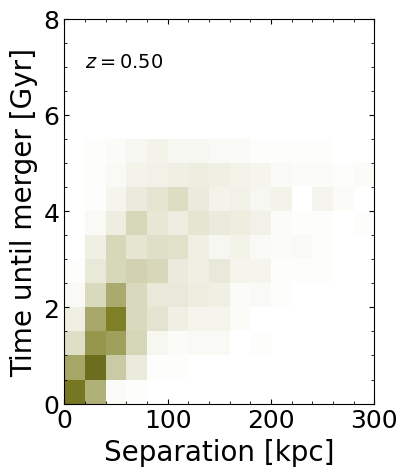

In [13]:
fig, ax = plt.subplots(1,1,figsize=(4, 5))

cmap=green_map
data = low
kwargs = {"range":[[0,300],[0,8]],
          "bins": [15,16],
          "cmap":cmap,
          "weights":100*np.ones(number_seps)/number_seps,
          "vmin":0,
          "vmax":20
         }
ax.text(20,7, r'$z=%.2f$' % (convert['Redshift'][snapnum]),fontsize=14)

ax.hist2d(seps_for_hist, mt_for_hist,**kwargs)
# fig.text(0.07, top_yloc, r"Time until merger [Gyr]", **ylabel_kwargs) 
ax.set(xlabel="Separation [kpc]", ylabel=r"Time until merger [Gyr]") 
plt.show()

In [14]:
print(seps_for_hist[:10])
print(mt_for_hist[:10])

[ 43.9024206   27.02093075  43.9024206   43.9024206  111.96043234
  64.12301413  32.42708684  56.439436   212.5768101  103.68961301]
[2.73579838 1.13724399 2.73579838 2.73579838 0.9689285  2.73579838
 0.9689285  1.59538311 2.73579838 2.42875496]


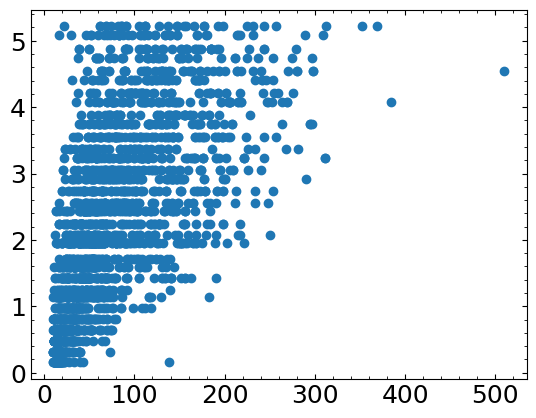

In [15]:
plt.scatter(seps_for_hist,mt_for_hist)
plt.show()

In [16]:
# masking out all separations greater than 300
mask300 = seps_for_hist < 300
seps_300 = seps_for_hist[mask300]
mt_300 = mt_for_hist[mask300]

xdat = np.reshape(seps_300,(len(seps_300),1))
ydat = mt_300

reg = LinearRegression(fit_intercept=False).fit(xdat, ydat)

slope = reg.coef_
intercept = reg.intercept_

## plotting fit

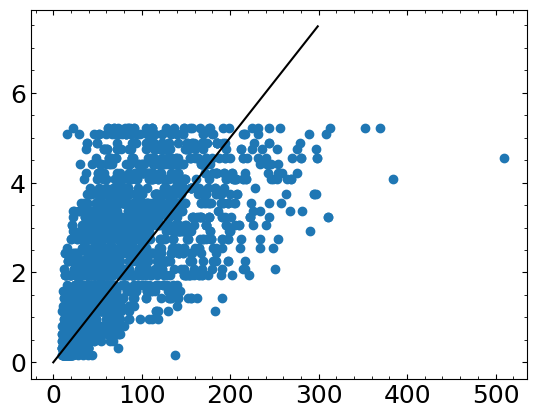

In [18]:
xx =  np.arange(0,300)
yy = xx*slope + intercept

plt.scatter(seps_for_hist,mt_for_hist)
plt.plot(xx,yy,color='black')
plt.show()

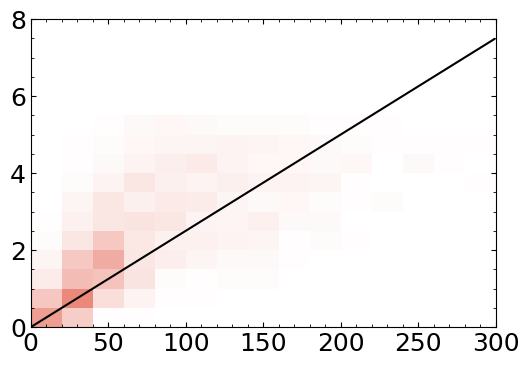

In [19]:
fig, ax = plt.subplots(1,1,figsize=(6, 4))

snapnum = 67
cmap=pink_map
data = low
kwargs = {"range":[[0,300],[0,8]],
          "bins": [15,16],
          "cmap":cmap,
          "weights":100*np.ones(number_seps)/number_seps,
          "vmin":0,
          "vmax":30
         }

ax.hist2d(seps_for_hist, mt_for_hist,**kwargs)
ax.plot(xx,yy,color='black')
plt.show()

## Trying with and without the intercept

In [20]:
# masking out all separations greater than 300
mask300 = seps_for_hist < 300
seps_300 = seps_for_hist[mask300]
mt_300 = mt_for_hist[mask300]

xdat = np.reshape(seps_300,(len(seps_300),1))
ydat = mt_300

reg_noint = LinearRegression(fit_intercept=False).fit(xdat, ydat)
reg_int = LinearRegression(fit_intercept=True).fit(xdat, ydat)

slope_noint = reg_noint.coef_ # intercept will be zero
slope_int = reg_int.coef_
intercept_int = reg_int.intercept_

xx = np.arange(0,300)
yy_noint = xx*slope_noint
yy_int = xx*slope_int + intercept_int

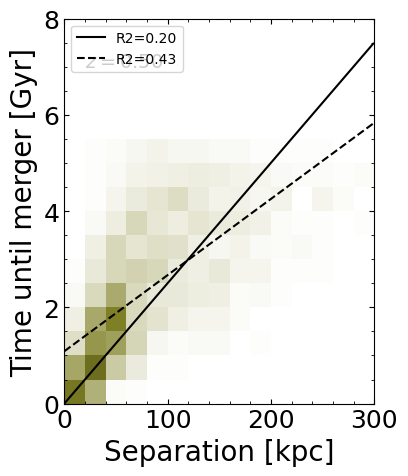

In [21]:
fig, ax = plt.subplots(1,1,figsize=(4, 5))

cmap=green_map
data = low
kwargs = {"range":[[0,300],[0,8]],
          "bins": [15,16],
          "cmap":cmap,
          "weights":100*np.ones(number_seps)/number_seps,
          "vmin":0,
          "vmax":20
         }
ax.text(20,7, r'$z=%.2f$' % (convert['Redshift'][snapnum]),fontsize=14)

ax.hist2d(seps_for_hist, mt_for_hist,**kwargs)
# fig.text(0.07, top_yloc, r"Time until merger [Gyr]", **ylabel_kwargs) 
ax.set(xlabel="Separation [kpc]", ylabel=r"Time until merger [Gyr]") 

r2val_noint = reg_noint.score(xdat, ydat)
r2val_int = reg_int.score(xdat, ydat)

ax.plot(xx,yy_noint,color='black',label=r'R2=%.2f'%r2val_noint)
ax.plot(xx,yy_int,color='black',linestyle='dashed',label=r'R2=%.2f'%r2val_int)

ax.legend(fontsize=10)


plt.show()

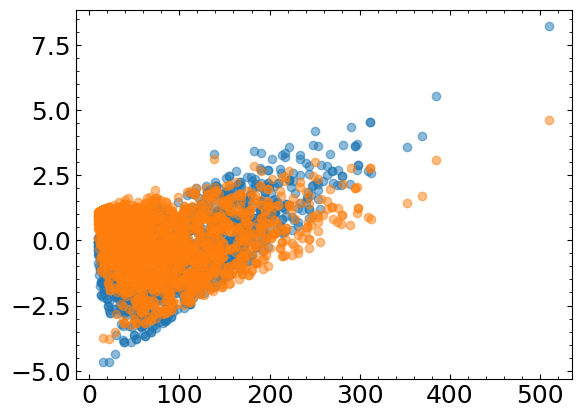

In [22]:
# residuals
res_noint = (seps_for_hist*slope_noint) - mt_for_hist
res_int = (seps_for_hist*slope_int + intercept_int) - mt_for_hist

plt.scatter(seps_for_hist, res_noint,alpha=0.5)
plt.scatter(seps_for_hist, res_int,alpha=0.5)

plt.show()

# adding a linear fit to each subplot

In [25]:
def get_best_fit(data, snapnum):
    """
    Requires convert to be defined prior to function execution 
    """

    lbt_at_snap = convert["Lookback Time"][snapnum]
    seps_at_snap = data['Separations'][:,snapnum]
    postinfall_at_snap = data['InfallSnapshot'] <= snapnum # infall snapshot must be = or prior to 40
    merge_later = data['MergeSnapshot'] > snapnum # merger snapshot must be after
    postinfall_willmerge = postinfall_at_snap&merge_later # merging pairs 
    seps_will_merge = np.where(postinfall_willmerge, seps_at_snap, np.nan)
    
    mask_lower10 = (seps_will_merge > 10)
    
    seps_for_hist = seps_will_merge[mask_lower10]
    number_seps = len(seps_for_hist)
    
    mergesnap = data['MergeSnapshot'][mask_lower10]
    mergetimes = convert["Lookback Time"][mergesnap]
    mt_for_hist = lbt_at_snap - mergetimes
    
    # creating x and y data of correct form    
    xdat = np.reshape(seps_for_hist,(len(seps_for_hist),1))
    ydat = mt_for_hist

    # perform fit
    reg = LinearRegression(fit_intercept=False).fit(xdat, ydat)        
    slope = reg.coef_ # intercept will be zero
    
    # create x,y data and R^2 score    
    xx = np.arange(0,300)
    yy = xx*slope
    r2val = reg.score(xdat, ydat)

    return xx, yy, r2val

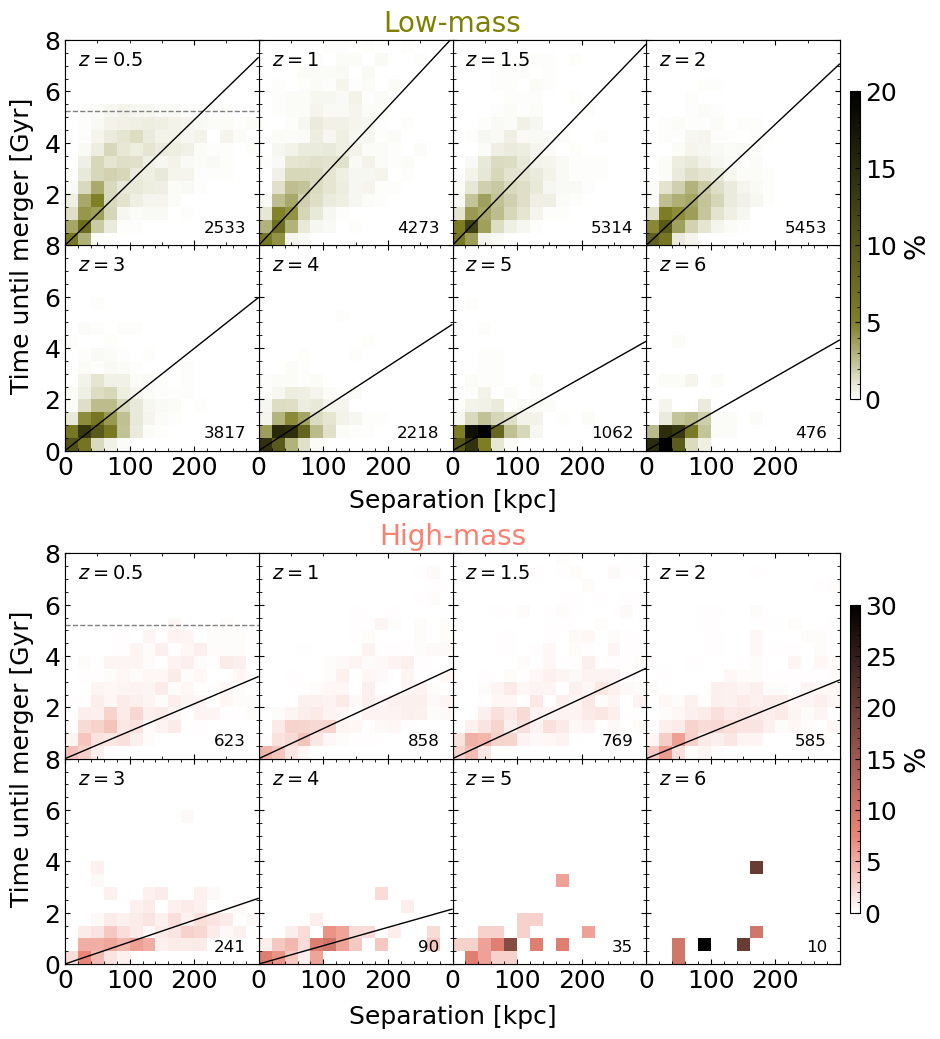

In [67]:
fig = plt.figure(figsize=(10, 12))
outer = gridspec.GridSpec(2, 1, wspace=0.2, hspace=0.25)

title_string = ["Low-mass","High-mass"]
title_color = [palette['low'],palette['high']]

redshift = [[0.5,1,1.5,2],[3,4,5,6]]
snaps = [[67,50,40,33],[25,21,17,13]]
timeleft = convert["Lookback Time"][67]
locs = {}

for outnum in range(2):
    inner = gridspec.GridSpecFromSubplotSpec(2, 4,
                    subplot_spec=outer[outnum], wspace=0, hspace=0)

    ax = plt.Subplot(fig, outer[outnum])
    ax.set_title(title_string[outnum], color=title_color[outnum], fontsize=20)
    ax.set_xticks([])
    ax.set_yticks([])
    
    fig.add_subplot(ax)
    locs[outnum] = ax.get_position()
    
    for rownum in range(2)[::-1]:        
        for colnum in range(4)[::-1]:
            ax = plt.Subplot(fig, inner[rownum,colnum])
            ax.set(ylim=(0,8),xlim=(0,300))
            snapnum = snaps[rownum][colnum]

            # changing the colormap and normalization for low vs. high
            if outnum == 0:
                _,grbar, numseps = add_2dhist(low, snapnum, ax)
                x_fit, y_fit, score_fit = get_best_fit(low, snapnum)
            elif outnum == 1:
                _,pnkbar, numseps = add_2dhist(high, snapnum, ax, cmap=pink_map, vmax=30)
                x_fit, y_fit, score_fit = get_best_fit(high, snapnum)

            # creating labels for redshift and number of pairs
            ax.text(20,7, r'$z=%s$' % (redshift[rownum][colnum]),fontsize=14)
            ax.text(280,0.5, r'%i' % (numseps),fontsize=12,ha='right')

            # creating horizontal dashed line at z=0 
            if (colnum == 0)&(rownum == 0):
                ax.axhline(timeleft, linestyle="dashed", lw=1, color='grey')
            
            # managing ticks:
            if colnum != 0:
                ax.tick_params(labelleft=False)    
            if rownum != 1:
                ax.tick_params(labelbottom=False)    
                ax.set_yticks(ticks=np.arange(2,9,2))
            else: 
                ax.set_xticks(ticks=[0, 100, 200])
            ax.set_ylabel(" ")
            ax.set_xlabel(" ")

            # only add fit lines if numseps > 50
            if numseps > 50:
                ax.plot(x_fit,y_fit,color='black',lw=1)
            
            fig.add_subplot(ax)

# locations : 
xloc = locs[0].x0+((locs[0].x1-locs[0].x0)/2)    
top_yheight = locs[0].y1-locs[0].y0
top_yloc = locs[0].y0+(top_yheight/2)
bottom_yheight = locs[1].y1-locs[1].y0
bottom_yloc = locs[1].y0+(bottom_yheight/2)

# colorbar:
loc_xcax = 0.91
loc_ycax = locs[0].y0+top_yheight/8
height_cax = 6*top_yheight/8
width_cax = 0.01
colorbar_kwargs = {"aspect":30, "location":"right",
                   "shrink":0.8,"pad":0.01,"label":"%"}

cax = fig.add_axes([loc_xcax, locs[0].y0+top_yheight/8, width_cax, height_cax])
fig.colorbar(grbar, cax=cax, **colorbar_kwargs)

cax = fig.add_axes([loc_xcax, locs[1].y0+top_yheight/8, width_cax, height_cax])
fig.colorbar(pnkbar, cax=cax, **colorbar_kwargs)


## labels:
xlabel_kwargs = {"fontsize":18, 
                 "ha":'center', 
                 "weight":'medium'}

ylabel_kwargs = {"rotation":'vertical',
                 "fontsize":18, 
                 "va":'center', 
                 "weight":'medium'}

# top plot:  
fig.text(0.07, top_yloc, r"Time until merger [Gyr]", **ylabel_kwargs) 
fig.text(xloc, 0.49, "Separation [kpc]", **xlabel_kwargs) 

# bottom plot: 
fig.text(0.07, bottom_yloc, r"Time until merger [Gyr]", **ylabel_kwargs) 
fig.text(xloc, 0.06, "Separation [kpc]", **xlabel_kwargs) 

fig.show()
plt.savefig("../../plots/bet-on-it/10_2Dhist_fits.png", bbox_inches="tight")

# make table of slopes for fits

In [29]:
def get_slopenscore(data, snapnum):
    """
    Requires convert to be defined prior to function execution 
    ---
    creates the fit for 
    """

    lbt_at_snap = convert["Lookback Time"][snapnum]
    seps_at_snap = data['Separations'][:,snapnum]
    postinfall_at_snap = data['InfallSnapshot'] <= snapnum # infall snapshot must be = or prior to 40
    merge_later = data['MergeSnapshot'] > snapnum # merger snapshot must be after
    postinfall_willmerge = postinfall_at_snap&merge_later # merging pairs 
    seps_will_merge = np.where(postinfall_willmerge, seps_at_snap, np.nan)
    
    mask_lower10 = (seps_will_merge > 10)
    
    seps_for_hist = seps_will_merge[mask_lower10]
    number_seps = len(seps_for_hist)
    
    mergesnap = data['MergeSnapshot'][mask_lower10]
    mergetimes = convert["Lookback Time"][mergesnap]
    mt_for_hist = lbt_at_snap - mergetimes
    
    # creating x and y data of correct form    
    xdat = np.reshape(seps_for_hist,(len(seps_for_hist),1))
    ydat = mt_for_hist

    # perform fit
    reg = LinearRegression(fit_intercept=False).fit(xdat, ydat)        
    slope = reg.coef_ # intercept will be zero
    r2val = reg.score(xdat, ydat)

    return slope, r2val




In [52]:
snaps = [67,50,40,33,25,21,17,13]
redshift = [0.5,1,1.5,2,3,4,5,6]


low_slopes = []
for en, snapnum in enumerate(snaps):
    slope_add, score_add = get_slopenscore(low, snapnum)
    low_slopes.append([snapnum, redshift[en], slope_add[0], score_add])

low_slopes = np.array(low_slopes)

high_slopes = []
for en, snapnum in enumerate(snaps):
    slope_add, score_add = get_slopenscore(high, snapnum)
    high_slopes.append([snapnum, redshift[en], slope_add[0], score_add])

high_slopes = np.array(high_slopes)

In [53]:
low_slopes

array([[6.70000000e+01, 5.00000000e-01, 2.44425615e-02, 1.72612655e-01],
       [5.00000000e+01, 1.00000000e+00, 2.69723770e-02, 2.87700235e-01],
       [4.00000000e+01, 1.50000000e+00, 2.61428583e-02, 3.09218365e-01],
       [3.30000000e+01, 2.00000000e+00, 2.36029145e-02, 1.98784827e-01],
       [2.50000000e+01, 3.00000000e+00, 1.99111684e-02, 1.15448563e-01],
       [2.10000000e+01, 4.00000000e+00, 1.64196469e-02, 1.34798007e-01],
       [1.70000000e+01, 5.00000000e+00, 1.42193405e-02, 1.10989299e-01],
       [1.30000000e+01, 6.00000000e+00, 1.43983387e-02, 1.32408669e-01]])

In [54]:
high_slopes

array([[6.70000000e+01, 5.00000000e-01, 1.06764977e-02, 9.15188376e-03],
       [5.00000000e+01, 1.00000000e+00, 1.17296005e-02, 3.41617158e-01],
       [4.00000000e+01, 1.50000000e+00, 1.17507008e-02, 3.12605028e-01],
       [3.30000000e+01, 2.00000000e+00, 1.02415532e-02, 2.23272430e-01],
       [2.50000000e+01, 3.00000000e+00, 8.54332698e-03, 1.21415383e-01],
       [2.10000000e+01, 4.00000000e+00, 7.13628559e-03, 2.54659196e-01],
       [1.70000000e+01, 5.00000000e+00, 8.32686609e-03, 3.25542974e-01],
       [1.30000000e+01, 6.00000000e+00, 1.14828827e-02, 3.13460830e-01]])

In [55]:
high_slopes[:,1]

array([0.5, 1. , 1.5, 2. , 3. , 4. , 5. , 6. ])

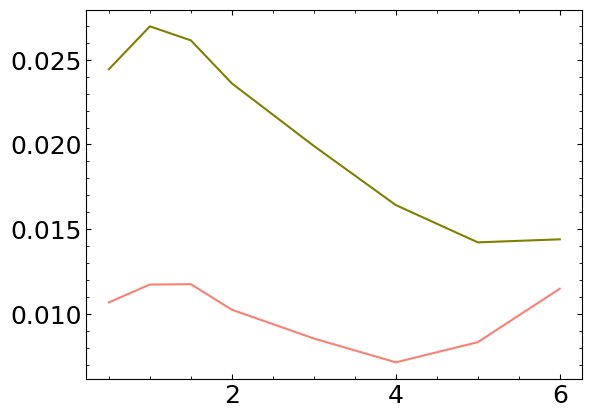

In [57]:
reds = high_slopes[:,1]
his = high_slopes[:,2]
lows = low_slopes[:,2]
plt.plot(reds, his, color=palette['high'])
plt.plot(reds, lows,color=palette['low'])
plt.show()

In [66]:
print(r"Redshift & Low-mass slope & High-mass slope\\\hline")
for i in range(len(reds)):
    print(rf"{low_slopes[i,1]} & {low_slopes[i,2]:0.3f} & {high_slopes[i,2]:0.3f} \\")

Redshift & Low-mass slope & High-mass slope\\\hline
0.5 & 0.024 & 0.011 \\
1.0 & 0.027 & 0.012 \\
1.5 & 0.026 & 0.012 \\
2.0 & 0.024 & 0.010 \\
3.0 & 0.020 & 0.009 \\
4.0 & 0.016 & 0.007 \\
5.0 & 0.014 & 0.008 \\
6.0 & 0.014 & 0.011 \\
